In [1]:
# 핵심 패키지(스트리밍 호환 버전)
!pip -q install "datasets<3.0.0" "evaluate<0.5.0" "transformers>=4.38,<4.45" \
                huggingface_hub torchaudio jiwer soundfile

# fsspec/gcsfs 충돌 정리
!pip -q install -U fsspec==2025.3.0 gcsfs

import datasets, evaluate, transformers, fsspec, gcsfs, sys
print("datasets:", datasets.__version__)    # ← 2.x 여야 OK
print("evaluate:", evaluate.__version__)    # ← 0.4.x 권장
print("transformers:", transformers.__version__)
print("fsspec:", fsspec.__version__)
print("gcsfs:", gcsfs.__version__)
print("python:", sys.version)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 94.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are inst

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset, Audio, Dataset, concatenate_datasets
from transformers import (
    WhisperProcessor, WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback
)
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from evaluate import load as load_metric
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

import os, random, numpy as np, torch

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("Seed fixed to {}.".format(SEED))

Seed fixed to 42.


In [4]:
# 2) 데이터 로드(Streaming -> in-memory)
# 🔄 원본 2배: n_train을 400으로 증가
n_train, n_val, n_test = 400, 100, 100
langs = ["ko","ja","en","de"]

def take_valid(gen, n, lang_code):
    out = []
    for ex in gen:
        if ex.get("audio") is not None and ex.get("sentence"):
            ex = dict(ex)
            ex["locale"] = lang_code
            out.append(ex)
            if len(out) >= n:
                break
    return out

train_data, val_data, test_data = [], [], []
for lang in langs:
    print(f"✅ Loading {lang}...")
    ds_tr = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="train",      streaming=True)
    ds_va = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="validation", streaming=True)
    ds_te = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="test",       streaming=True)
    train_data += take_valid(ds_tr, n_train, lang)
    val_data   += take_valid(ds_va, n_val,   lang)
    test_data  += take_valid(ds_te, n_test,  lang)

random.shuffle(train_data); random.shuffle(val_data); random.shuffle(test_data)
train_dataset = Dataset.from_list(train_data)
val_dataset   = Dataset.from_list(val_data)
test_dataset  = Dataset.from_list(test_data)
print({"train": len(train_dataset), "val": len(val_dataset), "test": len(test_dataset)})

✅ Loading ko...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for mozilla-foundation/common_voice_16_1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_16_1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Reading metadata...: 401it [00:00, 1335.13it/s]
Reading metadata...: 235it [00:00, 868.10it/s]
Reading metadata...: 282it [00:00, 965.88it/s]


✅ Loading ja...


Reading metadata...: 9616it [00:00, 13929.85it/s]
Reading metadata...: 6094it [00:00, 14347.94it/s]
Reading metadata...: 6094it [00:00, 14455.10it/s]


✅ Loading en...


Reading metadata...: 1090061it [00:23, 46975.67it/s]
Reading metadata...: 16390it [00:00, 21803.48it/s]
Reading metadata...: 16390it [00:00, 34317.50it/s]


✅ Loading de...


Reading metadata...: 576207it [00:12, 47487.59it/s]
Reading metadata...: 16173it [00:00, 21709.81it/s]
Reading metadata...: 16173it [00:00, 28179.04it/s]


{'train': 1600, 'val': 400, 'test': 400}


In [5]:
# 3) 전처리
TARGET_SR = 16000
model_checkpoint = "openai/whisper-small"

processor = WhisperProcessor.from_pretrained(model_checkpoint)
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer

train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=TARGET_SR))
val_dataset   = val_dataset.cast_column("audio",   Audio(sampling_rate=TARGET_SR))
test_dataset  = test_dataset.cast_column("audio",  Audio(sampling_rate=TARGET_SR))

def prepare_dataset(example):
    a = example["audio"]
    example["input_features"] = feature_extractor(a["array"], sampling_rate=TARGET_SR).input_features[0]
    example["labels"] = tokenizer(example["sentence"]).input_ids
    return example

keep_cols = {"input_features","labels","locale"}
proc_train_orig = train_dataset.map(prepare_dataset, remove_columns=[c for c in train_dataset.column_names if c not in keep_cols])
proc_val_orig   = val_dataset.map(  prepare_dataset, remove_columns=[c for c in val_dataset.column_names   if c not in keep_cols])
proc_test_orig  = test_dataset.map( prepare_dataset, remove_columns=[c for c in test_dataset.column_names  if c not in keep_cols])

for ds_ in (proc_train_orig, proc_val_orig, proc_test_orig):
    ds_.set_format(columns=list(keep_cols))

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device, "| Seed:", SEED)

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Device: cuda | Seed: 42


In [6]:
# 4) 모델 로딩 & Whisper generate() 안전 세팅
model = WhisperForConditionalGeneration.from_pretrained(model_checkpoint).to(device)

# pad/eos/start/forced 프롬프트 확정
tok = processor.tokenizer
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

start_id = tok.convert_tokens_to_ids("<|startoftranscript|>")
if start_id is None:
    start_id = processor.get_decoder_prompt_ids(language="english", task="transcribe")[0][1]

forced_ids_en = processor.get_decoder_prompt_ids(language="english", task="transcribe")

for cfg in (model.config, model.generation_config):
    cfg.pad_token_id = tok.pad_token_id
    cfg.eos_token_id = tok.eos_token_id
    cfg.decoder_start_token_id = start_id
    cfg.forced_decoder_ids = forced_ids_en

model.config.use_cache = False
model.config.suppress_tokens = []

# 5) Collator: 라벨 패딩 & decoder_input_ids 생성(우리가 명시 제공)
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    padding: Union[bool, str] = True
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 입력 피처
        input_features = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 라벨 패딩 + -100 마스킹
        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels.contiguous()

        # decoder_input_ids (right-shift with <|startoftranscript|>)
        tok = self.processor.tokenizer
        start_id = tok.convert_tokens_to_ids("<|startoftranscript|>")
        if start_id is None:
            start_id = self.processor.get_decoder_prompt_ids(language="english", task="transcribe")[0][1]
        pad_id = tok.pad_token_id

        labels_clean = labels.clone()
        labels_clean[labels_clean == -100] = pad_id

        dec_inp = torch.full_like(labels_clean, fill_value=pad_id)
        dec_inp[:, 0] = start_id
        dec_inp[:, 1:] = labels_clean[:, :-1]

        batch["decoder_input_ids"] = dec_inp.contiguous()
        batch["decoder_attention_mask"] = (dec_inp != pad_id).long()
        batch["input_features"] = batch["input_features"].contiguous()
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [7]:
# (SoX/증강 함수들은 남겨둬도 무방하지만, 여기선 사용하지 않음)
!apt-get -y install sox libsox-dev libsox-fmt-all

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss
  libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-dev libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base
  libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1 sox
0 upgraded, 17 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,157 kB of archives.
After this operation, 4,262 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 liba

In [8]:
import numpy as np, torchaudio
def _to_tensor_1ch(x_np):
    x = torch.tensor(np.asarray(x_np, dtype=np.float32))
    if x.dim() == 1:
        x = x.unsqueeze(0)
    return x
def speed_perturb_np(wav_np, sr, rate: float):
    if rate == 1.0:
        return wav_np, sr
    try:
        wav = _to_tensor_1ch(wav_np)
        effects = [["tempo", str(rate)]]
        aug, sr_out = torchaudio.sox_effects.apply_effects_tensor(wav, sr, effects)
        return aug.squeeze(0).numpy(), sr_out
    except Exception as e:
        print("[WARN][sox] tempo failed -> fallback(no-aug):", e)
        return wav_np, sr
train_raw_16k = train_dataset.cast_column("audio", Audio(sampling_rate=TARGET_SR))
def augment_copy(ds_raw, rate: float):
    def _aug(b):
        a = b["audio"]
        aug_np, sr_out = speed_perturb_np(a["array"], a["sampling_rate"], rate)
        b = dict(b)
        b["audio"] = {"array": aug_np, "path": None, "sampling_rate": sr_out}
        return b
    ds_aug = ds_raw.map(_aug)
    ds_proc = ds_aug.map(
        prepare_dataset,
        remove_columns=[c for c in ds_aug.column_names if c not in {"input_features","labels","locale"}]
    )
    ds_proc.set_format(columns=["input_features","labels","locale"])
    return ds_proc

# === 여기서부터: 증강 없음 — 원본만(언어별 400개) 사용 ===
proc_train_mix = proc_train_orig.shuffle(seed=SEED)
print("Train(orig x2):", len(proc_train_mix))

Train(orig x2): 1600


In [9]:
# 7) Trainer 설정 (기타 조건 동일)
args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-orig_x2",  # 원하면 이전 경로로 유지해도 됨
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    num_train_epochs=8,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    max_grad_norm=1.0,
    fp16=torch.cuda.is_available(),
    report_to="none",

    predict_with_generate=True,      # eval/predict 시 generate 사용
    generation_max_length=225,

    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    remove_unused_columns=False,
)

trainer_orig2x = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=proc_train_mix,
    eval_dataset=proc_val_orig,
    tokenizer=processor.tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

print("[sanity] before train:", trainer_orig2x.state.global_step)
trainer_orig2x.train()
print("[sanity] after  train:", trainer_orig2x.state.global_step)

[sanity] before train: 0


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.957293
2,No log,1.950114
3,2.222100,1.983032
4,2.222100,2.033867


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-cust

[sanity] after  train: 800


In [10]:
# 8) 평가
LANG_NAME = {"ko":"korean", "ja":"japanese", "en":"english", "de":"german"}
wer_metric = load_metric("wer"); cer_metric = load_metric("cer")

def eval_on(ds_proc, trainer_obj, label, sample_k=10, show_samples=True):
    rows = []
    for lang in ["ko","ja","en","de"]:
        subset = ds_proc.filter(lambda x: x["locale"] == lang)
        if len(subset) == 0:
            print(f"[WARN] No samples for {lang} in {label}")
            rows.append({"set": label, "lang": lang, "WER": float("nan"), "CER": float("nan"), "N": 0})
            continue

        forced_ids = processor.get_decoder_prompt_ids(language=LANG_NAME[lang], task="transcribe")
        trainer_obj.model.generation_config.forced_decoder_ids = forced_ids
        trainer_obj.model.generation_config.max_length = 225

        out = trainer_obj.predict(subset)
        preds = tokenizer.batch_decode(out.predictions, skip_special_tokens=True)
        label_ids = np.where(out.label_ids != -100, out.label_ids, tokenizer.pad_token_id)
        refs  = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

        wer = wer_metric.compute(predictions=preds, references=refs)
        cer = cer_metric.compute(predictions=preds, references=refs)
        rows.append({"set": label, "lang": lang, "WER": wer, "CER": cer, "N": len(refs)})

        if show_samples and sample_k > 0:
            print(f"\n[{label}] {lang.upper()} samples (k={min(sample_k, len(refs))})")
            for i, (p, r) in enumerate(zip(preds, refs)):
                if i >= sample_k: break
                print(f"#{i:02d} PRED: {p}")
                print(f"     REF : {r}")
                print("---")
    return pd.DataFrame(rows).sort_values("lang")

print(f"[CHECK] Evaluating on TEST set: size={len(proc_test_orig)} (val={len(proc_val_orig)})")
df_orig = eval_on(proc_test_orig, trainer_orig2x, "test_orig", sample_k=10, show_samples=True)
display(df_orig)
df_orig.to_csv("/content/results_orig_x2_test_orig_ONLY.csv", index=False)
print("Saved -> /content/results_orig_x2_test_orig_ONLY.csv")

[CHECK] Evaluating on TEST set: size=400 (val=400)


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



[test_orig] KO samples (k=10)
#00 PRED: 놈댓더면 찾지 말고 해결체가 되다라
     REF : 문제점을 찾지 말고 해결책을 찾아라.
---
#01 PRED: 신철이는 저헷발을 바라보면서 지금 11시 번이나 되었을 것을 짐작하였다.
     REF : 신철이는 저 햇발을 바라보면서 지금 열한시 반이나 되었을 것을 짐작하였다.
---
#02 PRED: 할멈은 올가을의 새로운 이 무명사골이를 아까워서 잊지 못하고 주웠던 것이다.
     REF : 할멈은 올 가을에 새로한 이 무명저고리를 아까워서 입지 못하고 두었던 것이다.
---
#03 PRED: 그들은 이 종잇조각을 발견할 때마다 머리를 맞대고 재민하게 읽어 보았다.
     REF : 그들은 이 종잇조각을 발견할 때마다 머리를 맞대고 재미나게 읽어 보았다.
---
#04 PRED: 마스크 잘 쓰고 다니고 길쥐 조심해서 다녀와
     REF : 마스크 잘 쓰고 다니고, 길 조심해서 다녀와.
---
#05 PRED: 건덜패와 논단이들이 얼어져서 약물이 아닌 누룩국물을 마시구 그심부름을 하는 모양이다.
     REF : 건달패와 논다니들이 어우러져서 약물이 아닌 누룩 국물을 마시고 그 심부름을 하는 모양이다.
---
#06 PRED: 이거나 놀아고
     REF : 이거 놔! 놓으라고!
---
#07 PRED: 지압이는 돌아오지않고 어린 딸은 돌아지 꽃이 좋아 돌묻어 무더운 것 같다.
     REF : 지아비는 돌아오지 않고 어린 딸은 도라지꽃이 좋아 돌무덤으로 갔다
---
#08 PRED: 그러나 또 얼마나 푸른 화려
     REF : 그러나 또 얼마나 불행하랴.
---
#09 PRED: 그런지라
     REF : 그런지라.
---


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig] JA samples (k=10)
#00 PRED: 高橋駆いと
     REF : 高橋海人
---
#01 PRED: 動物に合う
     REF : 動物にあう
---
#02 PRED: そこで自分で出かけていって、調べ始めました。彼はさんざん、探し回りました。
     REF : そこで自分で出かけて行って、調べはじめました。かれはさんざんさがしまわりました。
---
#03 PRED: いけたんすいですよ。
     REF : 私は、猫の鼻先をわざと、五六回、行ったり来たりしてやりました。それから、ずっと側まで近づいて行ってみました。
---
#04 PRED: ラブストーリー
     REF : ラブストーリー
---
#05 PRED: ただこの国で一枚の夢のみなとまちだったころの記録映像は観ていた。
     REF : ただ、この国で一番有名な港町だったころの記録映像は見ていた
---
#06 PRED: 指をつめて、足や耳に両者は、歯になり、枝になり、茎を鼻めらになって、重なりつながり、根しれに、特別の形を作っていた。
     REF : 指や爪、手や足や耳に似たものが、葉になり、枝になり、茎や花びらになって、重なり、繋がり、捻れ、植物の形を作っていた
---
#07 PRED: 膝をすりむいた
     REF : 膝を擦りむいた
---
#08 PRED: だがコトワル
     REF : だが断る
---
#09 PRED: 君の前にしに僕は似合わないからな。
     REF : 君の毎日に僕は似合わないかな
---


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig] EN samples (k=10)
#00 PRED: Maybe he just put it there for safekeeping?
     REF : Maybe he just put it there for safe keeping?
---
#01 PRED: They found one such edge in the Farweand system.
     REF : They found one such edge in Fairbairn's system.
---
#02 PRED: A bit later on the firetruck was not long enough.
     REF : The ladder on the fire truck was not long enough.
---
#03 PRED: She'll be alright.
     REF : She'll be all right.
---
#04 PRED: Gabby Hospital, I met a very nice nurse.
     REF : At the hospital, I met a very nice nurse.
---
#05 PRED: I pointed out Mars a bright dot of light.
     REF : I pointed out Mars, a bright dot of light.
---
#06 PRED: He ended up running to the bars which fortified the windows of the first floor.
     REF : He ended up running to the bars which fortified the windows of the first floor.
---
#07 PRED: That man is your brother?
     REF : That man is your brother?
---
#08 PRED: Religious festivals include the Muslim Eids and the C

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig] DE samples (k=10)
#00 PRED: Sie gewannen das Match mit sechs Lösern vorschsprungen.
     REF : Sie gewannen das Match mit sechs Löchern Vorsprung.
---
#01 PRED: Zu seinen weiteren Aufgaben gehört die Abnahme von neu eingekauften oder geliechten Flugzeugen.
     REF : Zu seinen weiteren Aufgaben gehört die Abnahme von neu eingekauften oder geleasten Flugzeugen.
---
#02 PRED: Es kommt zum Schreudewagen der Hand.
     REF : Es kommt zum Showdown in Gstaad.
---
#03 PRED: Es gibt auch mehrere Gewingplätze.
     REF : Es gibt auch mehrere Campingplätze.
---
#04 PRED: Dieses ist der erste Messer der Meckern mit dem Hördnussabli.
     REF : Zusätzlich wird noch zwischen Messgrößen und Messmethoden unterschieden.
---
#05 PRED: Sie wurden nach der Stadt Boise in Eiderhoe benannt.
     REF : Sie wurde nach der Stadt Boise in Idaho benannt.
---
#06 PRED: Dieleich können sie uns diese Frage am Ende der Aussprache beantworten.
     REF : Vielleicht können Sie uns diese Frage am Ende der

,set,lang,WER,CER,N
3,test_orig,de,0.301549,0.113162,100
2,test_orig,en,0.236872,0.116563,100
1,test_orig,ja,0.909910,0.341748,100
0,test_orig,ko,0.431242,0.194503,100


Saved -> /content/results_orig_x2_test_orig_ONLY.csv


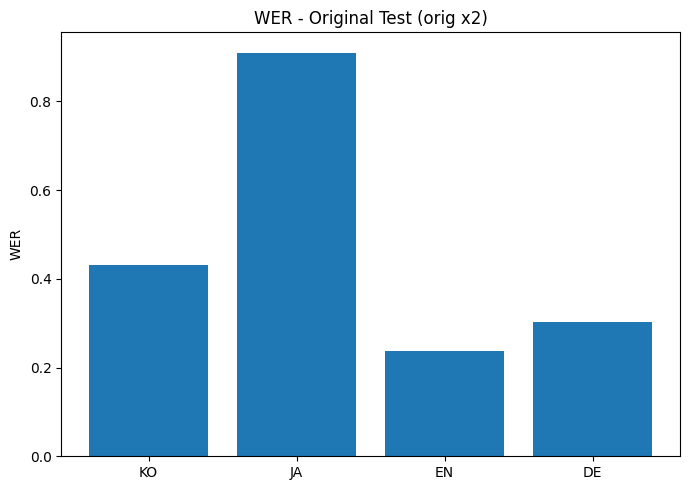

In [11]:
# 9) 시각화
def bar_lang(df, label):
    plt.figure(figsize=(7,5))
    langs = ["ko","ja","en","de"]
    vals = []
    for l in langs:
        row = df[df["lang"]==l]
        vals.append(float(row["WER"].values[0]) if len(row) else float("nan"))
    plt.bar([l.upper() for l in langs], vals)
    plt.title(f"WER - {label}")
    plt.ylabel("WER")
    plt.tight_layout()
    plt.show()

bar_lang(df_orig, "Original Test (orig x2)")